# Walkthrough notebook for the APPLESOSS (A Producer of ProfiLEs for SOSS) Module
Construct spatial profiles based on a given observed dataset for the first three SOSS orders to be used as the specprofile reference file in the ATOCA algorithm.

In [1]:
from astropy.io import fits
from matplotlib.colorbar import Colorbar
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from sys import path
soss_path = '/Users/michaelradica/Documents/GitHub/jwst-mtl/'
path.insert(1, soss_path)

from SOSS.dms.soss_centroids import get_soss_centroids
from SOSS.APPLESOSS.utils import replace_badpix
from SOSS.APPLESOSS import applesoss

/Users/michaelradica/.anaconda3/envs/soss/lib/python3.7/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/michaelradica/Documents/GitHub/BEARS/BEARS_ref-files/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/michaelradica/.anaconda3/envs/soss/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/michaelradica/Documents/GitHub/BEARS/BEARS_ref-files/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/michaelradica/.anaconda3/envs/soss/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/michaelradica/Documents/GitHub/BEARS/BEARS_ref-files/grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-034 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-051
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [2]:
clear_cv3 = fits.getdata('/Users/michaelradica/transfer/stack_clear.fits', 0)

# Add a floor level so that all pixels are positive.
floor = np.nanpercentile(clear_cv3, 0.1)
clear_cv3 -= floor

# Replace bad pixels.
clear_cv3 = replace_badpix(clear_cv3, verbose=3)
clear_cv3 += floor

  5%|▍         | 96/2048 [00:07<02:29, 13.03it/s]


KeyboardInterrupt: 

100%|██████████| 2048/2048 [02:37<00:00, 13.01it/s]


   0.14% of pixels interpolated.


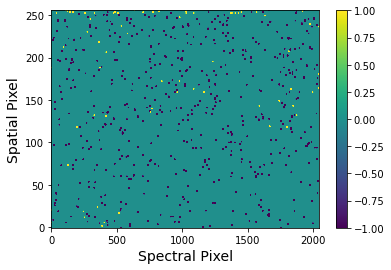

In [13]:
# Open a simulated data set.
clear = fits.getdata('Ref_files/simulated_data.fits', 0)

# Add a floor level so that all pixels are positive.
floor = np.nanpercentile(clear, 0.1)
clear -= floor

# Replace bad pixels.
clear = replace_badpix(clear, verbose=3)
clear += floor

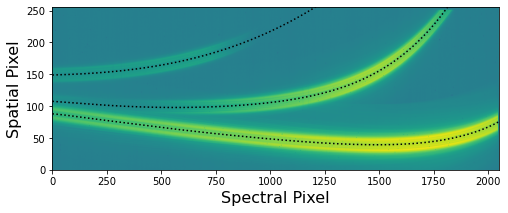

In [4]:
# Get the trace centroids for all three orders.
cen = get_soss_centroids(clear, subarray='SUBSTRIP256')

# Plot the data frames
fig = plt.figure(figsize=(8, 3))
plt.imshow(np.log10(clear), origin='lower', aspect='auto')
plt.plot(cen['order 1']['X centroid'], cen['order 1']['Y centroid'], ls=':', c='black')
plt.plot(cen['order 2']['X centroid'], cen['order 2']['Y centroid'], ls=':', c='black')
plt.plot(cen['order 3']['X centroid'], cen['order 3']['Y centroid'], ls=':', c='black')

plt.xlabel('Spectral Pixel', fontsize=16)
plt.ylabel('Spatial Pixel', fontsize=16)
plt.ylim(0, 256)
plt.show()

# Add back the floor level
clear += floor

The ```EmpiricalProfile``` class of APPLESOSS is the workhorse of this module. To initialize it, it requires a CLEAR exposure data frame. Optional arguments are the amount of padding to add around the edges of the frames, as well as the factor of oversampling. Additionally, a the soss_width parameter should be set to the same value as will be used in the ATOCA extraction. It defaults (like ATOCA) to 40 pixels. 

Call ```build_empirical_profile``` once the class is initialized to reconstruct the spatial profiles for the first, second, and third orders. 

Afterwards, the ```write_specprofile_reference``` method can be called to save the profiles to an external file for use as the specprofile reference file needed by the ATOCA algorithm.

In [63]:
import importlib
import utils
importlib.reload(applesoss)
importlib.reload(utils)

<module 'utils' from '/Users/michaelradica/Documents/GitHub/jwst-mtl/SOSS/APPLESOSS/utils.py'>

In [ ]:
spat_prof = applesoss.EmpiricalProfile(clear, verbose=1)
spat_prof.build_empirical_profile()

Starting the APPLESOSS module.

 Initial processing...
  Interpolating bad pixels...
  Getting trace centroids...
  Starting the first order model...
    Generating 23 PSFs. Expected to take about 0.96 mins.


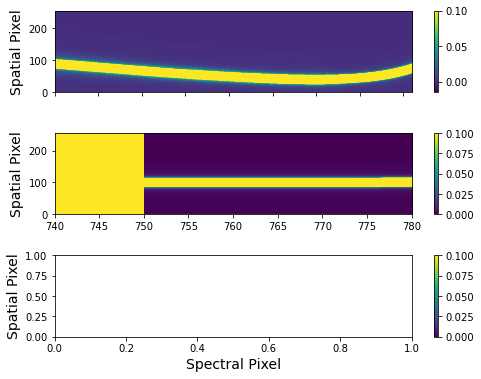

In [60]:
# Show the spatial profile models for each order.
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])

ax1 = plt.subplot(gs[0])
plt.imshow(spat_prof.order1, origin='lower', aspect='auto', vmax=0.1)
plt.colorbar()
ax1.set_ylabel('Spatial Pixel', fontsize=14)
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax2 = plt.subplot(gs[1])
plt.imshow(spat_prof.order2, origin='lower', aspect='auto', vmin=0, vmax=0.1)
plt.colorbar()
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.set_ylabel('Spatial Pixel', fontsize=14)

ax3 = plt.subplot(gs[2])
plt.imshow(spat_prof.order3, origin='lower', aspect='auto', vmin=0, vmax=0.1)
plt.colorbar()
ax3.set_xlabel('Spectral Pixel', fontsize=14)
ax3.set_ylabel('Spatial Pixel', fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()

In [10]:
# Open the true spatial profiles which were seeded in the simulation and bin down to 
# native resolution.
ref = fits.open('/Users/michaelradica/transfer/ref_profile_realization0.fits')

array = ref[1].data[40:-40, 40:-40]
shape = np.shape(array)
binned_array = array.reshape(256, 4, 2048, 4)
mod_1 = binned_array.mean(-1).sum(1)

array = ref[2].data[40:-40, 40:-40]
shape = np.shape(array)
binned_array = array.reshape(256, 4, 2048, 4)
mod_2 = binned_array.mean(-1).sum(1)

array = ref[3].data[40:-40, 40:-40]
shape = np.shape(array)
binned_array = array.reshape(256, 4, 2048, 4)
mod_3 = binned_array.mean(-1).sum(1)

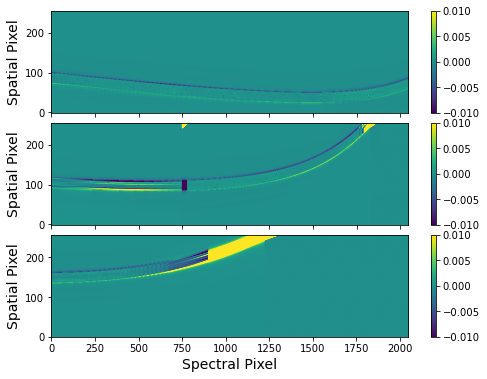

In [16]:
# Compare the APPLESOSS profiles to the reference profiles.
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])

ax1 = plt.subplot(gs[0])
plt.imshow(spat_prof.order1 - mod_1, origin='lower', aspect='auto', vmin=-1e-2, vmax=1e-2)
plt.colorbar()
ax1.set_ylabel('Spatial Pixel', fontsize=14)
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax2 = plt.subplot(gs[1])
plt.imshow(spat_prof.order2 - mod_2, origin='lower', aspect='auto', vmin=-1e-2, vmax=1e-2)
plt.colorbar()
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.set_ylabel('Spatial Pixel', fontsize=14)

ax3 = plt.subplot(gs[2])
plt.imshow(spat_prof.order3 - mod_3, origin='lower', aspect='auto', vmin=-1e-2, vmax=1e-2)
plt.colorbar()
ax3.set_xlabel('Spectral Pixel', fontsize=14)
ax3.set_ylabel('Spatial Pixel', fontsize=14)

plt.xlim(0, 2048)
plt.ylim(0, 256)

plt.subplots_adjust(hspace=0.1)
plt.show()

In [13]:
# Create a SUBSTRIP256 spatial profile reference file
spat_prof.write_specprofile_reference('SUBSTRIP256')

Saving to file APPLESOSS_ref_2D_profile_SUBSTRIP256_os2_pad20.fits
